In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.optimize import root_scalar

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
c = 3e8  # Speed of light in m/s
mu0 = 4 * np.pi * 1e-7  # Permeability of free space (H/m)

In [4]:
n1, n2, n3 = 1.5, 2.0, 1.8
d1, d2 ,d3 = 1.5e-6, 1.7e-6, 1.0e-6
d3 += d1
d2 += d3
wavelength = 1.55e-6  # Wavelength in meters

k0 = 2 * np.pi / wavelength  # Free-space wave number
omega = 2 * np.pi * c / wavelength 

In [5]:
#n = [n1, n2, n1, n2, n1]  # Refractive indices of layers (including substrate and cladding)
n = [n1, n2, n1, n3, n1] 
d = [np.inf, d1, d3, d2]  # Thickness of each layer (excluding substrate and cladding)
alpha = [1.0, 1.0, 1.0, 1.0, 1.0]

In [6]:
def calculate_pk(beta, n_k, k0):
    """
    Calculate p_k based on beta and the refractive index n_k.
    """
    p_k_squared = np.sqrt(np.abs(beta**2 - (n_k * k0)**2))
    if beta > n_k * k0:
        return p_k_squared
    elif beta < n_k * k0:
        return 1j * p_k_squared
    else:
        return 0  # Handle the edge case where p_k is zero

In [7]:
def transfer_matrix(p_k, p_k1, d_k):
    if d_k == np.inf:
        d_k = 0
    
    a = np.exp((p_k - p_k1) * d_k)
    b = np.exp((p_k + p_k1) * d_k)
    r = (1 + (p_k) / (p_k1))
    s = (1 - (p_k) / (p_k1))

    T = np.squeeze(0.5 * np.array([[a * r, s / b],
                                  [b * s, r / a]]))
    return T

In [8]:
def total_tm(beta, n, d, k0):
    num_layers = len(d)
    T_total = np.eye(2)
    T_list = []
    T_list.append(T_total)
    for k in range(num_layers):
        p_k = calculate_pk(beta, n[k], k0)
        p_k1 = calculate_pk(beta, n[k + 1], k0)
        T_k = transfer_matrix(p_k, p_k1, d[k])
        T_total = T_k @ T_total
        T_list.append(T_total)
    return T_total, T_list

In [9]:
def radiation_condition(beta):
    T, _ = total_tm(beta, n, d, k0)
    return T[0,0].real

In [10]:
beta_min = max(n[0], n[-1]) * k0 + 1e-9  # Slightly above the substrate/cladding limit
beta_max = max(n) * k0 - 1e-9  # Slightly below the maximum refractive index

solutions = []

In [11]:
def find_betas(beta_min, beta_max, n, d, k0, steps=10000):
    beta_range = np.linspace(beta_min, beta_max, steps)
    
    for i in range(len(beta_range) - 1):
        f_a = radiation_condition(beta_range[i])
        f_b = radiation_condition(beta_range[i + 1])
        
        if f_a * f_b <= 0:
            root = root_scalar(radiation_condition, bracket=(beta_range[i], beta_range[i + 1]), method='brentq')
            solutions.append(root.root)
            
    return sorted(solutions, reverse=True)

In [12]:
betas = find_betas(beta_min, beta_max, n, d, k0)
# Print the mode number, beta, and n_effective
print("Mode\tBeta (m^-1)\tn_effective")

for mode_number, beta in enumerate(betas, start=0):
    n_effective = beta / k0
    print(f"{mode_number}\t{beta:.6e}\t{n_effective:.6f}")

Mode	Beta (m^-1)	n_effective
0	7.933116e+06	1.957022
1	7.403673e+06	1.826413
2	7.156359e+06	1.765403
3	6.740354e+06	1.662779
4	6.529718e+06	1.610817
5	6.122509e+06	1.510363


In [13]:
def calculate_p_list(beta, n, k0):
    pk = []
    for i in range(len(n)):
        pk.append(calculate_pk(beta, n[i], k0))
    return pk

In [14]:
def calculate_amplitudes(matrices):
    amps = []
    initial_amp = np.array([1,0])
    for matrix in matrices:
        amps.append(np.dot(matrix, initial_amp))
    return amps

In [15]:
def calculate_E(beta, x):
    p = calculate_p_list(beta, n, k0)
    _,T_list = total_tm(beta, n, d, k0)
    amps = calculate_amplitudes(T_list)
    
    field_profile = np.zeros_like(x)
    
    sub = x < 0
    layer1 = (0 <= x) & (x < d1)
    layer2 = (d1 <= x) & (x < d3)
    layer3 = (d3 <= x) & (x < d2)
    clad = x >= d2
    
    field_profile[sub] = amps[0][0] * np.exp(p[0] * x[sub]) + amps[0][1] * np.exp(-p[0] * x[sub])
    field_profile[layer1] = amps[1][0] * np.exp(p[1] * x[layer1]) + amps[1][1] * np.exp(-p[1] * x[layer1])
    field_profile[layer2] = amps[2][0] * np.exp(p[2] * x[layer2]) + amps[2][1] * np.exp(-p[2] * x[layer2])
    field_profile[layer3] = amps[3][0] * np.exp(p[3] * x[layer3]) + amps[3][1] * np.exp(-p[3] * x[layer3])
    field_profile[clad] = amps[4][0] * np.exp(p[4] * x[clad]) + amps[4][1] * np.exp(-p[4] * x[clad])

    # Normalize 
    dx = x[1] - x[0]
    integral = np.trapz(np.abs(field_profile) ** 2, dx=dx) 
    normalization_factor = np.sqrt(2 * omega * mu0 / (beta * integral))
    field_profile *= normalization_factor
    return x, field_profile

In [16]:
def reflective_indicies_profile(n, x):
    sub = x < 0
    layer1 = (0 <= x) & (x < d1)
    layer2 = (d1 <= x) & (x < d3)
    layer3 = (d3 <= x) & (x < d2)
    clad = x >= d2

    n_profile = np.zeros_like(x)

    n = n
    n_profile[sub] = n[0] - min(n)
    n_profile[layer1] = n[1] - min(n)
    n_profile[layer2] = n[2] - min(n)
    n_profile[layer3] = n[3] - min(n)
    n_profile[clad] = n[4] - min(n)
    
    return n_profile

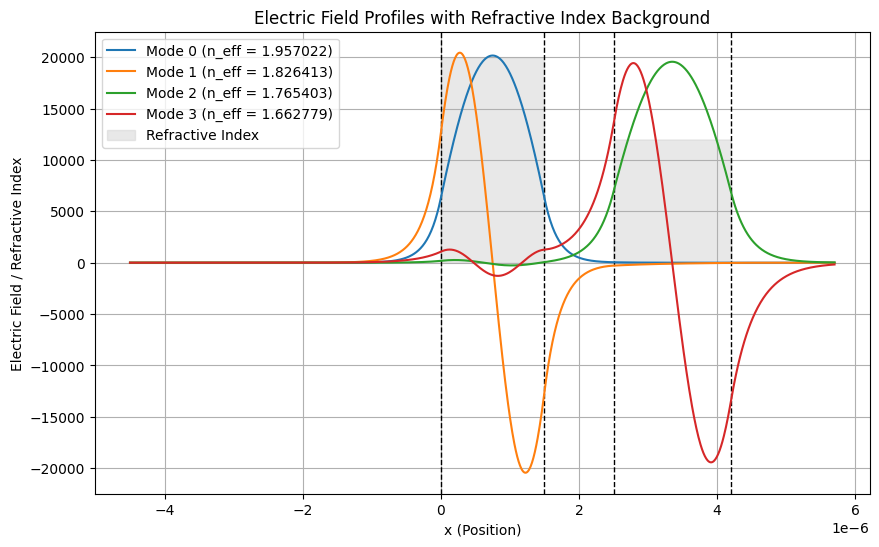

In [17]:
x = np.linspace(-3 * d1, d2 + d1, 1000)

first_four_betas = betas[:4]
# Get the refractive index profile
n_profile_values = reflective_indicies_profile(n, x) * 4e+4

# Start plotting
plt.figure(figsize=(10, 6))

boundary_positions = [0] + d
for boundary in boundary_positions:
    plt.axvline(boundary, color='black', linestyle='--', linewidth=1)
    
# Plot the electric field profiles for the first four fundamental modes
for i, beta in enumerate(first_four_betas, start=0):
    # Calculate the electric field for the current mode
    x_field, E_field = calculate_E(beta, x)  # Replace with your function and parameters
    plt.plot(x_field, E_field, label=f"Mode {i} (n_eff = {(beta / k0):.6f})")

# Add labels, title, legend, and grid
plt.xlabel("x (Position)")
# Plot the refractive index profile as a background
plt.fill_between(x, n_profile_values, color='lightgray', alpha=0.5, label="Refractive Index")
plt.ylabel("Electric Field / Refractive Index")
plt.title("Electric Field Profiles with Refractive Index Background")

plt.legend()
plt.grid()
plt.show()

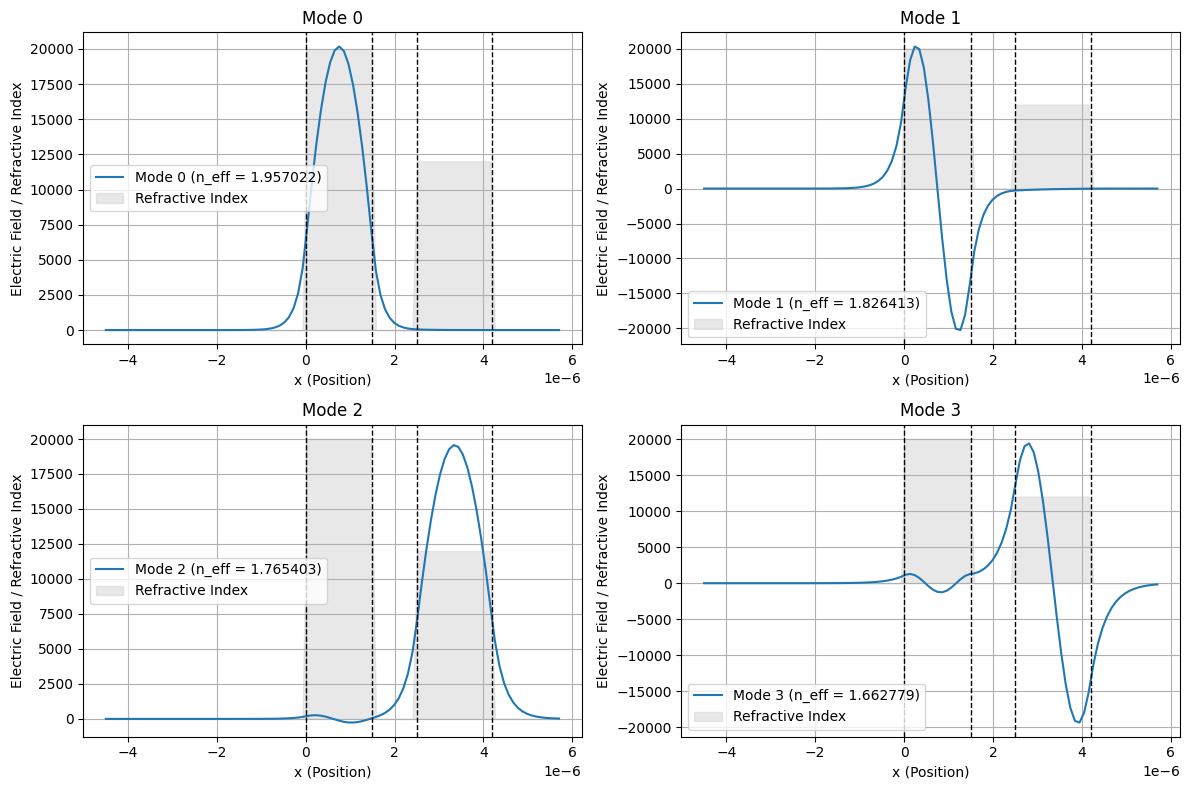

In [19]:
# Example data and parameters
x = np.linspace(-3 * d1, d2 + d1, 1000)
first_four_betas = betas[:4]  # Replace `betas` with your actual data
n_profile_values = reflective_indicies_profile(n, x) * 4e+4  # Replace with your function
boundary_positions = [0] + d  # Replace `d` with your actual boundaries

# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

for i, beta in enumerate(first_four_betas, start=0):
    # Determine the row and column for the current subplot
    row, col = divmod(i, 2)
    ax = axs[row, col]
    
    # Calculate the electric field for the current mode
    x_field, E_field = calculate_E(beta, x)  # Replace with your function and parameters

    # Plot the electric field profile for the current mode
    ax.plot(x_field, E_field, label=f"Mode {i} (n_eff = {(beta / k0):.6f})")
    
    # Plot the refractive index profile as a background
    ax.fill_between(x, n_profile_values, color='lightgray', alpha=0.5, label="Refractive Index")
    
    # Add vertical boundary lines
    for boundary in boundary_positions:
        ax.axvline(boundary, color='black', linestyle='--', linewidth=1)
    
    # Customize subplot
    ax.set_xlabel("x (Position)")
    ax.set_ylabel("Electric Field / Refractive Index")
    ax.set_title(f"Mode {i}")
    ax.legend()
    ax.grid()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
